In [2]:
from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Balanceacc

from models import efficientNetV2B0_model, efficientNetV2B3_model
from config import efficientNet_config

import cv2 as cv
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import os
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
height  = efficientNet_config['height_B0']
width   = efficientNet_config['width_B0']
input_shape  = efficientNet_config['input_shape_B0']

# 讀取資料

In [4]:
train_dir      = '../dataset_186video_20230323/train'
validation_dir = '../dataset_186video_20230323/validation/'

In [5]:
train_img_arrays = []
train_img_labels = []
validation_img_arrays = []
validation_img_labels = []

## train
img_paths = glob(train_dir + "/0/*.png")
for img_path in img_paths:
    # imege
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))     # resize to (224,224)
    train_img_arrays.append(img_array)
    #label
    train_img_labels.append([0])

img_paths = glob(train_dir + "/1/*.png")
for img_path in img_paths:
    # imege
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))      # resize to (224,224)
    train_img_arrays.append(img_array)
    #label
    train_img_labels.append([1])


## validation
img_paths = glob(validation_dir + "/0/*.png")
for img_path in img_paths:
    # imege
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))      # resize to (224,224)
    validation_img_arrays.append(img_array)
    #label
    validation_img_labels.append([0])

img_paths = glob(validation_dir + "/1/*.png")
for img_path in img_paths:
    # imege
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))      # resize to (224,224)
    validation_img_arrays.append(img_array)
    #label
    validation_img_labels.append([1])

In [6]:
print('訓練集數量= ', len(train_img_labels))
print('驗證集數量= ', len(validation_img_labels))

訓練集數量=  6724
驗證集數量=  2695


In [7]:
train_img_arrays = np.array(train_img_arrays)
train_img_labels = np.array(train_img_labels)
validation_img_arrays = np.array(validation_img_arrays)
validation_img_labels = np.array(validation_img_labels)

In [8]:
train_img_arrays, train_img_labels = shuffle(train_img_arrays,train_img_labels)
validation_img_arrays, validation_img_labels = shuffle(validation_img_arrays,validation_img_labels)

In [9]:
print('訓練集維度= ',train_img_arrays.shape)
print('測試集維度= ',validation_img_arrays.shape)

訓練集維度=  (6724, 224, 224, 3)
測試集維度=  (2695, 224, 224, 3)


# 模型建立

In [10]:
model = efficientNetV2B0_model()

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-2),
              metrics=['accuracy', 
                        Balanceacc()
                      ])


2023-04-08 21:14:11.100252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:14:11.104726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:14:11.105405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-08 21:14:11.106275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [11]:
day = '20230401'
checkpoint_filepath = '../model/202303/{}.weights'.format(day)
model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_balanceacc',
        mode='max',
        save_best_only=True)

# learning rate 降低
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1,
#                               patience=5, 
#                               min_lr=1e-6)



callbacks = [model_checkpoint_callback, 
             #reduce_lr
             ]

In [12]:
# 訓練
epochs = 10
history = model.fit(
      x = train_img_arrays,
      y = train_img_labels,
      validation_data = (validation_img_arrays,validation_img_labels),      
      epochs          = epochs,
      verbose         = 1,
      callbacks       = callbacks
)

2023-04-08 21:14:13.198026: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1012150272 exceeds 10% of free system memory.
2023-04-08 21:14:13.845826: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1012150272 exceeds 10% of free system memory.


Epoch 1/10


2023-04-08 21:14:20.186770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


211/211 [==============================] - 34s 130ms/step - loss: 0.2788 - accuracy: 0.8919 - balanceacc: 0.8920 - val_loss: 0.2758 - val_accuracy: 0.9069 - val_balanceacc: 0.9068
Epoch 2/10
211/211 [==============================] - 26s 123ms/step - loss: 0.1978 - accuracy: 0.9253 - balanceacc: 0.9255 - val_loss: 0.1891 - val_accuracy: 0.9254 - val_balanceacc: 0.9255
Epoch 3/10
211/211 [==============================] - 25s 120ms/step - loss: 0.1702 - accuracy: 0.9355 - balanceacc: 0.9355 - val_loss: 0.2451 - val_accuracy: 0.8835 - val_balanceacc: 0.8834
Epoch 4/10
211/211 [==============================] - 26s 123ms/step - loss: 0.1669 - accuracy: 0.9372 - balanceacc: 0.9373 - val_loss: 0.1859 - val_accuracy: 0.9299 - val_balanceacc: 0.9299
Epoch 5/10
211/211 [==============================] - 26s 122ms/step - loss: 0.1449 - accuracy: 0.9478 - balanceacc: 0.9478 - val_loss: 0.2316 - val_accuracy: 0.9384 - val_balanceacc: 0.9385
Epoch 6/10
211/211 [==============================] - 25

# 畫圖

In [13]:
loss         = history.history['loss']
val_loss     = history.history['val_loss']
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
BlA          = history.history['balanceacc']
val_BlA      = history.history['val_balanceacc']

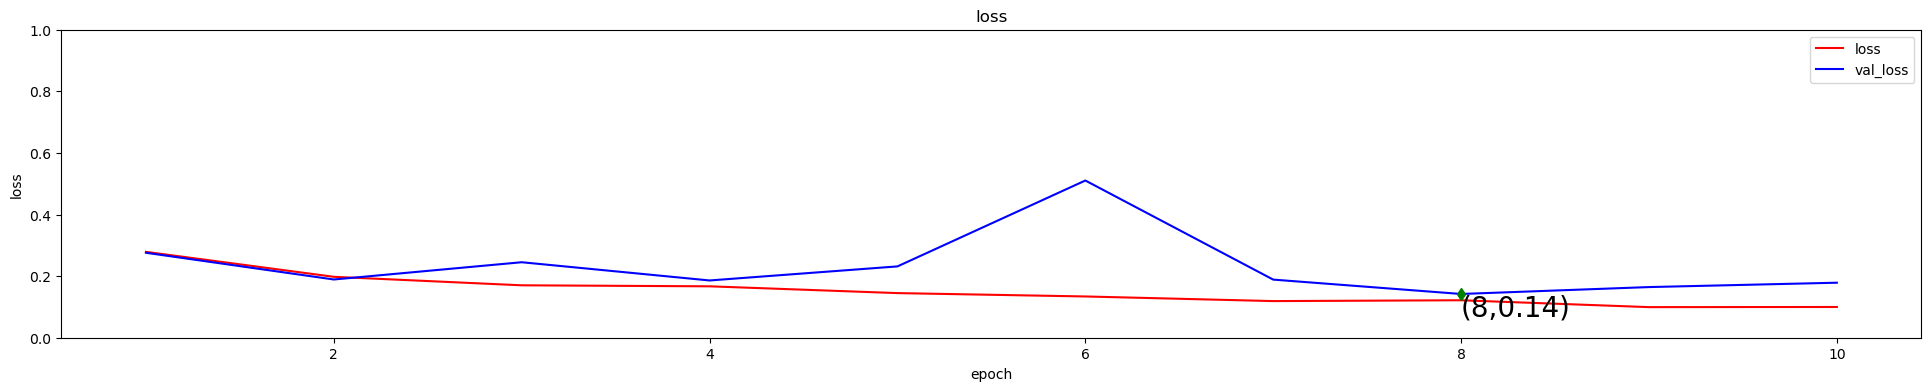

In [14]:
x = [i for i in range(1, epochs+1)]

min_valloss_x = val_loss.index(min(val_loss)) + 1
min_valloss_y = min(val_loss)

plt.figure(figsize=(24,4))
plt.plot(x, loss, 'r')     
plt.plot(x, val_loss, 'b')     # red dotted line (no marker)

plt.plot(min_valloss_x, min_valloss_y, 'd', color='g')
plt.text(min_valloss_x, min_valloss_y, "({},{})".format(min_valloss_x,round(min_valloss_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['loss','val_loss'])
plt.ylim((0, 1.0))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.savefig('../model/202303/{}_loss.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

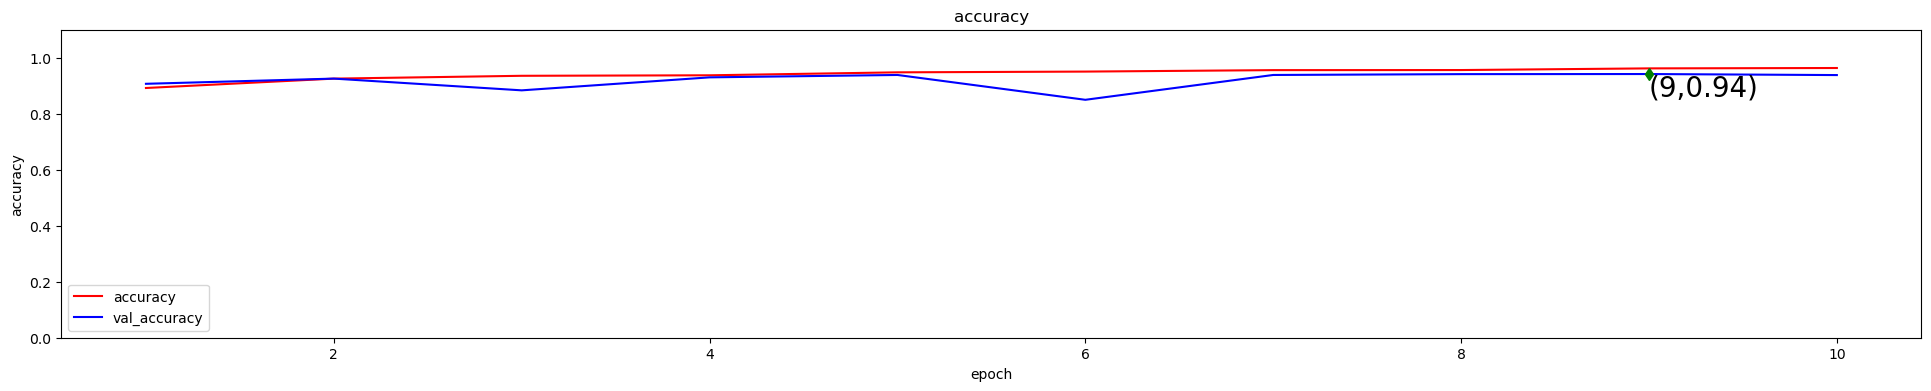

In [15]:
x = [i for i in range(1, epochs+1)]

max_valacc_x = val_accuracy.index(max(val_accuracy)) + 1
max_valacc_y = max(val_accuracy)

plt.figure(figsize=(24,4))
plt.plot(x, accuracy, 'r')     
plt.plot(x, val_accuracy, 'b')     # red dotted line (no marker)

plt.plot(max_valacc_x, max_valacc_y, 'd', color='g')
plt.text(max_valacc_x, max_valacc_y, "({},{})".format(max_valacc_x, round(max_valacc_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['accuracy','val_accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.savefig('../model/202303/{}_acc.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

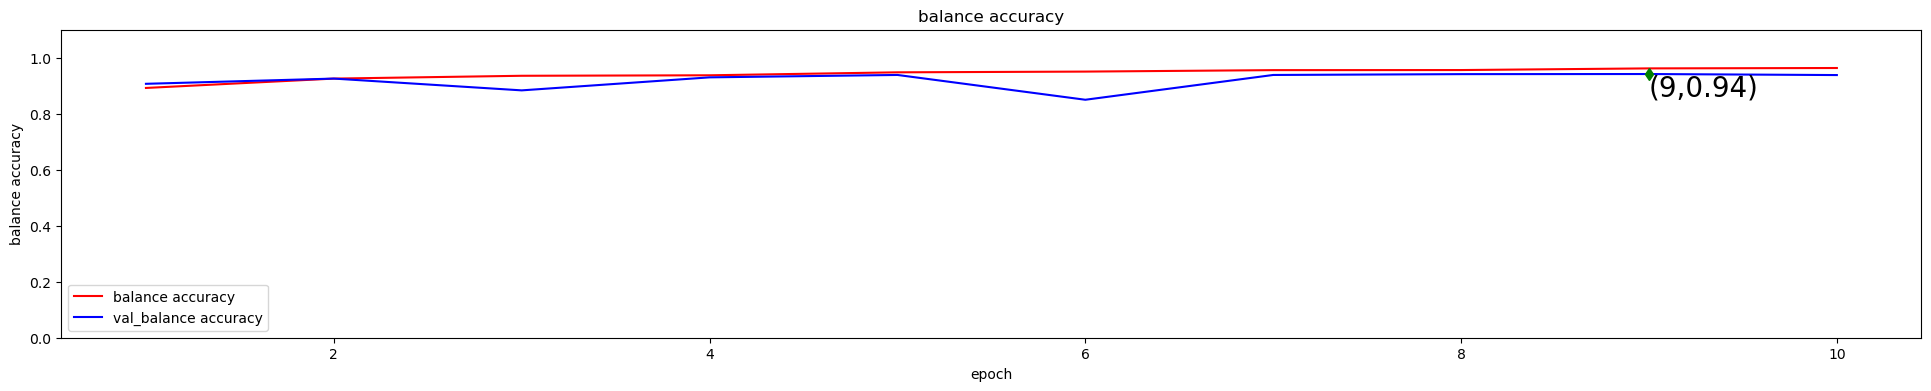

In [16]:
x = [i for i in range(1, epochs+1)]

max_valBlA_x = val_BlA.index(max(val_BlA)) + 1
max_valBlA_y = max(val_BlA)

plt.figure(figsize=(24,4))
plt.plot(x, BlA, 'r')     
plt.plot(x, val_BlA, 'b')     # red dotted line (no marker)

plt.plot(max_valBlA_x, max_valBlA_y, 'd', color='g')
plt.text(max_valBlA_x, max_valBlA_y, "({},{})".format(max_valBlA_x, round(max_valBlA_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['balance accuracy','val_balance accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('balance accuracy')
plt.title('balance accuracy')
plt.savefig('../model/202303/{}_BlA.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [17]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('../model/202303/{}.history'.format(day), 'w'))

In [18]:
# 也將最後一個epoch訓練的模型存下來
model.save("../model/202303/{}_lastepoch.h5".format(day))